In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# dat = pd.read_csv('../data/treasury/FY2020_020_Contracts_Full_20210109.zip')
# dat = dat.loc[(dat.modification_number=='0')&((dat.parent_award_agency_id=='2050')|(dat.awarding_sub_agency_code=='2050')|(dat.funding_sub_agency_code=='2050'))]
# dat.to_csv('../data/FY_2020.csv', index=False)

In [3]:
dfs = []
for fp in glob.glob('../data/treasury/*.zip'):
    if '2019' in fp or '2020' in fp:
        df = pd.read_csv(fp, low_memory=False, dtype={'modification_number':str, 'parent_award_agency_id':str, 'awarding_sub_agency_code':str, 'funding_sub_agency_code':str})
        df['fy'] = os.path.basename(fp)[2:6]
        dfs.append(df)
dat = pd.concat(dfs)

In [4]:
# IRS contracts only
dat = dat.loc[(dat.modification_number=='0')&((dat.parent_award_agency_id=='2050')|(dat.awarding_sub_agency_code=='2050')|(dat.funding_sub_agency_code=='2050'))]

In [5]:
dat['action_date'] = pd.to_datetime(dat['action_date'])
dat['solicitation_date'] = pd.to_datetime(dat['solicitation_date'])
dat['palt'] = (dat['action_date'] - dat['solicitation_date']).dt.days
dat = dat.loc[dat.palt.notnull()].reset_index(drop=True)

In [6]:
dat['palt'].describe()

count     924.000000
mean       96.812771
std       410.348039
min         0.000000
25%        12.000000
50%        22.000000
75%        41.000000
max      5051.000000
Name: palt, dtype: float64

In [7]:
dat['palt'].quantile(q=[0.05, 0.1, 0.9, 0.95, 0.99])

0.05       3.00
0.10       6.00
0.90      89.40
0.95     321.85
0.99    1424.97
Name: palt, dtype: float64

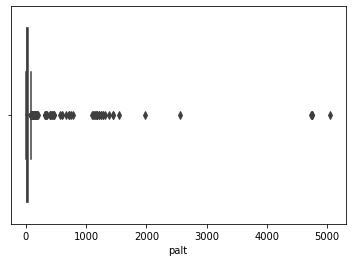

In [8]:
sns.boxplot(x='palt', data=dat)
plt.show()

In [9]:
# select 95%tile for outlier cutoff
palt = dat.loc[dat.palt<322].reset_index(drop=True)

In [10]:
palt.shape

(877, 284)

## Outlier detection

In [11]:
palt.groupby('fy').count()

,contract_transaction_unique_key,contract_award_unique_key,award_id_piid,modification_number,transaction_number,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,parent_award_modification_number,federal_action_obligation,...,highly_compensated_officer_2_amount,highly_compensated_officer_3_name,highly_compensated_officer_3_amount,highly_compensated_officer_4_name,highly_compensated_officer_4_amount,highly_compensated_officer_5_name,highly_compensated_officer_5_amount,usaspending_permalink,last_modified_date,palt
fy,,,,,,,,,,,,,,,,,,,,,
2019,287,287,287,287,286,246,246,246,246,287,...,81,78,78,78,78,77,77,287,287,287
2020,590,590,590,590,580,436,436,436,436,590,...,154,149,149,138,138,135,135,590,590,590


In [12]:
palt.palt.describe()

count    877.000000
mean      29.841505
std       31.705461
min        0.000000
25%       11.000000
50%       21.000000
75%       37.000000
max      321.000000
Name: palt, dtype: float64

In [13]:
palt.groupby('fy')['palt'].agg(['mean', 'median', 'std'])

,mean,median,std
fy,,,
2019,28.655052,21.0,26.187787
2020,30.418644,21.0,34.073913


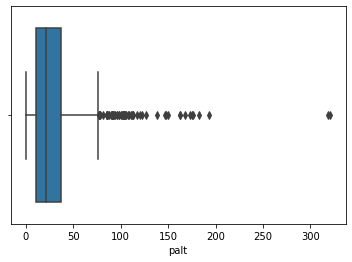

In [14]:
sns.boxplot(x='palt', data=palt)
plt.show()

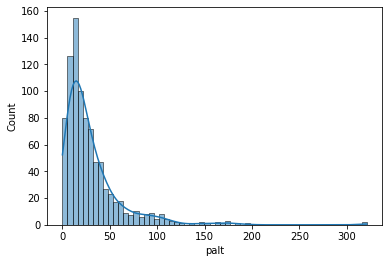

In [15]:
sns.histplot(x='palt', data=palt, kde=True)
plt.show()

In [16]:
desc_cols = palt.columns[palt.columns.str.lower().str.contains('description')]
desc_cols = [i for i in desc_cols if palt[i].notnull().any()]

## Word frequency

In [17]:
palt[list(desc_cols)+['palt']]

,foreign_funding_description,award_description,inherently_governmental_functions_description,product_or_service_code_description,naics_description,palt
0,NOT APPLICABLE,CFO FINANCIAL AUDIT AND ACCOUNTING SUPPORT SER...,CLOSELY ASSOCIATED,SUPPORT- MANAGEMENT: AUDITING,OTHER ACCOUNTING SERVICES,48.0
1,NOT APPLICABLE,FEDERAL GREEN BUILDING RESTACK SECURITY PROJEC...,OTHER FUNCTIONS,"INSTALLATION OF EQUIPMENT- ALARM, SIGNAL, AND ...",SECURITY SYSTEMS SERVICES (EXCEPT LOCKSMITHS),100.0
2,NOT APPLICABLE,DESAC V BRIDGE CONTRACT,NaN,INFORMATION TECHNOLOGY INPUT/OUTPUT AND STORAG...,OTHER COMPUTER RELATED SERVICES,8.0
3,NOT APPLICABLE,DELOITTE - ECM WEBAPPS REQUIREMENT 6MONTH BASE...,"CLOSELY ASSOCIATED,CRITICAL FUNCTIONS",IT AND TELECOM- SYSTEMS DEVELOPMENT,COMPUTER SYSTEMS DESIGN SERVICES,37.0
4,NOT APPLICABLE,"PURCHASE OF CISCO SWITCHES, ROUTERS, NETWORK T...",NaN,COMMUNICATIONS SECURITY EQUIPMENT AND COMPONENTS,OTHER COMPUTER RELATED SERVICES,11.0
...,...,...,...,...,...,...
872,NOT APPLICABLE,OAMP SUPPORT SERVICES,"CLOSELY ASSOCIATED,CRITICAL FUNCTIONS",SUPPORT- PROFESSIONAL: OTHER,ADMINISTRATIVE MANAGEMENT AND GENERAL MANAGEME...,5.0
873,NOT APPLICABLE,THE PURPOSE OF THIS FIRM FIXED PRICED DELIVERY...,NaN,INFORMATION TECHNOLOGY INPUT/OUTPUT AND STORAG...,OTHER COMPUTER RELATED SERVICES,9.0
874,NOT APPLICABLE,THIRD PARTY DATA SERVICE,"CLOSELY ASSOCIATED,CRITICAL FUNCTIONS",IT AND TELECOM- WEB-BASED SUBSCRIPTION,CREDIT BUREAUS,40.0
875,NOT APPLICABLE,CISCO ENTERPRISE LICENSE AGREEMENTS (ELA),NaN,INFORMATION TECHNOLOGY SOFTWARE,OTHER COMPUTER RELATED SERVICES,15.0


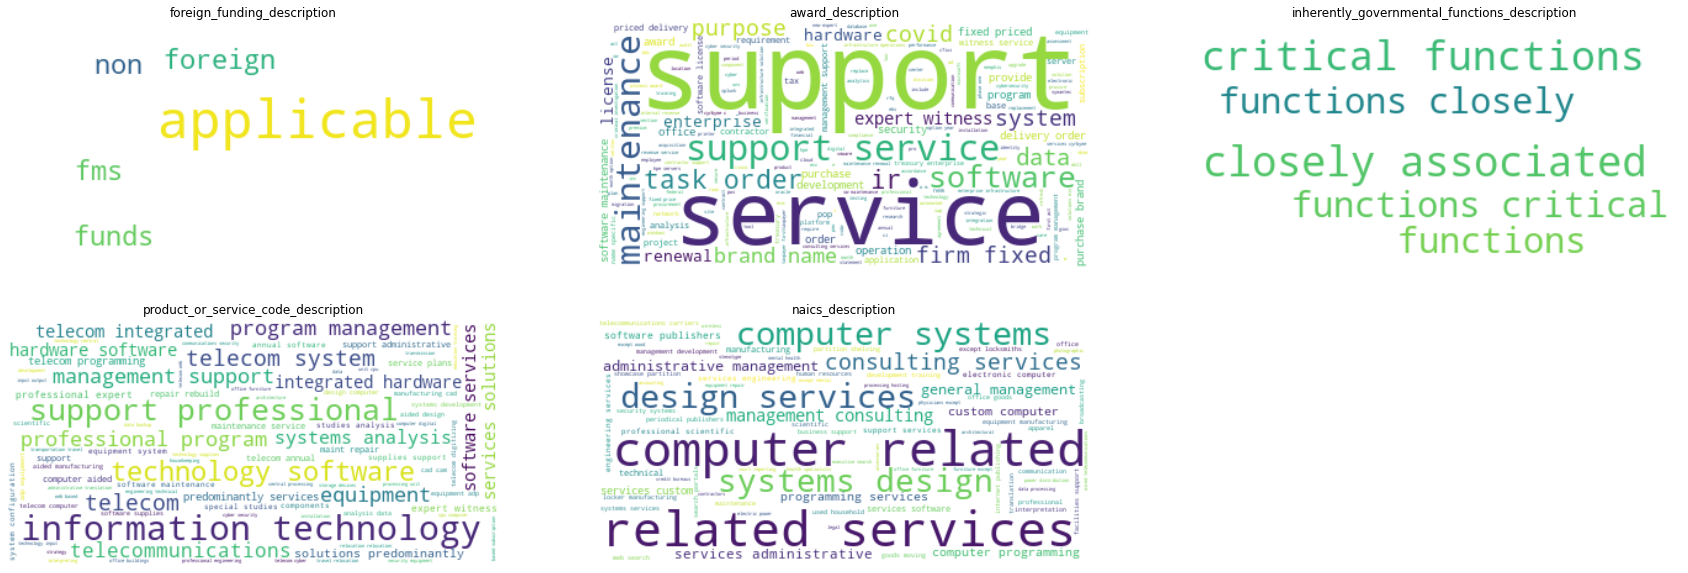

In [18]:
from wordcloud import WordCloud

# Display the generated image:
fig = plt.figure(figsize=(30, 10))
for i, v in enumerate(desc_cols):
    award_desc_text = ' '.join(palt[v].dropna()).lower()
    wordcloud = WordCloud(background_color='white').generate_from_text(award_desc_text)
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(v)
    ax.set_axis_off()

### Word pattern with regular expression

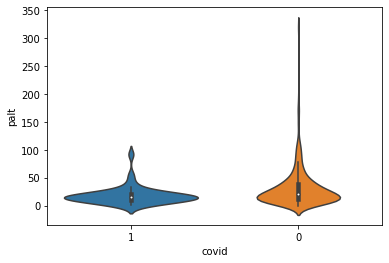

In [19]:
col = 'award_description'
matching_word = 'covid'
match = (palt[col].str.contains(matching_word, case=False))

group_name = matching_word
palt[group_name] = np.where(match, 1, 0)

sns.violinplot(x=group_name,
               y='palt',
               data=palt, 
               order=[1, 0],
               split=True)
# plt.legend(bbox_to_anchor=(1.05, 0.55), loc=2, borderaxespad=0.)
plt.show()

In [20]:
def r_squared_adj(data, group, dummy=True):
    y = data['palt']
    if dummy:
        x = data[group]
    else:
        x = pd.get_dummies(data[group], drop_first=True)
    x = sm.add_constant(x)
    mod = sm.OLS(y,x).fit()
    return mod.rsquared_adj.round(2)

In [21]:
matching_word

'covid'

In [22]:
r_squared_adj(palt, group_name, dummy=True)

0.01

## TF-IDF + k-mean clustering (cosine similarity)

In [23]:
import numpy as np
import pandas as pd
import nltk
# nltk.download()
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import mpld3

In [24]:
def tokenize_and_stem(text):
    stemmer = SnowballStemmer("english")
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [25]:
en_stopwords = nltk.corpus.stopwords.words('english')
domain_stopwords = ["OT", "CL", "CT", "option", "closeout", "contractor", "contract", "fund", "funding", "funds", "exercise", "service", "services", "cyrbyme", "support", "igf"]
stopwords = en_stopwords + [i.lower() for i in domain_stopwords]

In [26]:
text = ','.join(palt['award_description'])

In [27]:
col = 'award_description'
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in palt[col]:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [28]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 7450 items in vocab_frame


In [29]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, 
    max_features=2000,
    min_df=0.06, 
    stop_words=stopwords,
    use_idf=True, 
    tokenizer=tokenize_and_stem, 
    ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(palt[col].tolist())
print(tfidf_matrix.shape)

CPU times: user 204 ms, sys: 7.83 ms, total: 212 ms
Wall time: 214 ms
(877, 8)


/home/xiongxi/.cache/pypoetry/virtualenvs/palt-KWSO7McF-py3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'cyrbym', 'doe', 'dure', 'exercis', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'servic', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [30]:
terms = tfidf_vectorizer.get_feature_names()

In [31]:
terms

['enterpris',
 'mainten',
 'manag',
 'order',
 'servic',
 'softwar',
 'task',
 'task order']

In [32]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [33]:
np.random.seed(10)
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 199 ms, sys: 0 ns, total: 199 ms
Wall time: 54.2 ms


In [34]:
palt['tfidf_cluster'] = clusters
palt[terms] = tfidf_matrix.toarray()

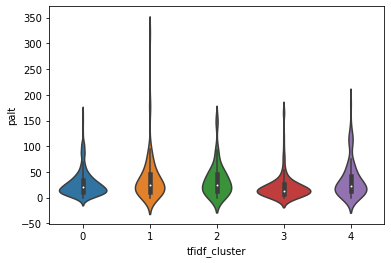

In [35]:
sns.violinplot(x='tfidf_cluster', 
               y='palt',
               data=palt)
plt.show()

In [36]:
palt.groupby('tfidf_cluster')['palt'].agg(['mean', 'median', 'std', 'count'])

,mean,median,std,count
tfidf_cluster,,,,
0,27.874396,21.0,24.828783,414
1,37.262857,25.0,44.500156,175
2,34.436364,24.0,31.995233,55
3,21.524138,14.0,25.113654,145
4,35.170455,22.0,35.620678,88


In [37]:
r_squared_adj(palt, 'tfidf_cluster', False)

0.02

## Supervised BERT classification

In [38]:
palt.loc[palt.palt<=11, 'palt_class'] = 'Very fast'
palt.loc[(palt.palt>11)&(palt.palt<=21), 'palt_class'] = 'Fast'
palt.loc[(palt.palt>21)&(palt.palt<=37), 'palt_class'] = 'Medium'
palt.loc[palt.palt>37, 'palt_class'] = 'Slow'

In [39]:
label_dict = {}
for index, possible_label in enumerate(palt.palt_class.unique()):
    label_dict[possible_label] = index
label_dict

{'Slow': 0, 'Very fast': 1, 'Medium': 2, 'Fast': 3}

In [40]:
palt['label'] = palt.palt_class.map(label_dict)

In [41]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    palt.index.values, 
    palt.label.values, 
    test_size=0.3, 
    random_state=100, 
    stratify=palt.palt_class.values)

In [43]:
palt.loc[X_train, 'split'] = 'train'
palt.loc[X_val, 'split'] = 'val'

In [44]:
palt.groupby(['palt_class', 'split'])['palt'].count()

palt_class  split
Fast        train    162
            val       70
Medium      train    139
            val       60
Slow        train    152
            val       65
Very fast   train    160
            val       69
Name: palt, dtype: int64

In [45]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', 
    do_lower_case=True)

In [46]:
encoded_data_train = tokenizer.batch_encode_plus(
    palt.loc[palt.split=='train', 'award_description'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest', 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    palt.loc[palt.split=='val', 'award_description'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest', 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(palt.loc[palt.split=='train', 'label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(palt.loc[palt.split=='val', 'label'].values)

In [47]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [48]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=palt.palt_class.unique().shape[0],
    output_attentions=False,
    output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [49]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(
    dataset_train, 
    sampler=RandomSampler(dataset_train), 
    batch_size=batch_size)

dataloader_validation = DataLoader(
    dataset_val, 
    sampler=SequentialSampler(dataset_val), 
    batch_size=batch_size)

In [50]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5, 
    eps=1e-8)

In [51]:
epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs)

In [52]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        
        
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [53]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [55]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.373575058216002
Validation loss: 1.3535294261845676
F1 Score (Weighted): 0.2881623101564451


Epoch 2:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.2595489333315593
Validation loss: 1.3771870515563271
F1 Score (Weighted): 0.2796709288203031


Epoch 3:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.1303651818415015
Validation loss: 1.3970911794088103
F1 Score (Weighted): 0.3382059427355988


Epoch 4:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9804491477768595
Validation loss: 1.4370369884100826
F1 Score (Weighted): 0.36810647154037573


Epoch 5:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9163447915053949
Validation loss: 1.4457062360915272
F1 Score (Weighted): 0.36693575396805184


In [56]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [57]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [58]:
accuracy_per_class(predictions, true_vals)

Class: Slow
Accuracy: 34/65

Class: Very fast
Accuracy: 16/69

Class: Medium
Accuracy: 1/60

Class: Fast
Accuracy: 36/70

